# Tutorial 3: Diffusion-based multimodal imputation

Tutorials 2 and 3 investigate a multimodal single-cell hair follicle dataset by [Ma et al., 2020](https://www.sciencedirect.com/science/article/pii/S0092867420312538). Data comes from female mouse dorsal skin and consists of two single-cell modalities: ATAC-seq (chromatin accessibility, raw data available on [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597)) and RNA-seq (gene expression, raw data available on [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608)).

The single-cell profiling of cells inevitably generates data of high sparsity levels, resulting in 0-inflated feature values that obstruct the inference of relationships between features. This section shows how to use Ocelli to strengthen a weak single-cell signal using diffusion-based multimodal imputation. This process restores the missing expression values by exponentiation of the multimodal Markov matrix to a power $t$ and multiplying the result by the original expression matrix.

Below, you will impute values of RNA-seq gene expression and ATAC-seq promoter activity of two hair follicle's Henle's lineage markers, Krt71 and Krt73.

## Loading and preprocessing data

Download filtered data, available on [figshare](https://doi.org/10.6084/m9.figshare.22700056.v2).

In [1]:
! wget --content-disposition https://figshare.com/ndownloader/articles/22700056/versions/4
! unzip -o 22700056.zip
! rm 22700056.zip

--2023-10-04 14:39:57--  https://figshare.com/ndownloader/articles/22700056/versions/4
Resolving figshare.com (figshare.com)... 52.49.59.79, 52.31.154.4, 2a05:d018:1f4:d003:63e2:30d7:6063:c9d7, ...
Connecting to figshare.com (figshare.com)|52.49.59.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167301210 (160M) [application/zip]
Saving to: ‘22700056.zip’

22700056.zip        100%[===================>] 159.55M  20.7MB/s    in 8.7s    

2023-10-04 14:40:06 (18.3 MB/s) - ‘22700056.zip’ saved [167301210/167301210]

Archive:  22700056.zip
 extracting: hair_follicle_atac.h5ad  
 extracting: hair_follicle_atac_peaks.h5ad  
 extracting: hair_follicle_rna.h5ad  
 extracting: hair_follicle_signature_HS_Co.csv  
 extracting: hair_follicle_signature_HS_Me.csv  
 extracting: hair_follicle_signature_IRS_He.csv  
 extracting: hair_follicle_signature_IRS_Hu.csv  


Preprocess data as in tutorial 2.

In [2]:
import anndata as ad
import scvelo as scv
from scipy.sparse import csr_matrix

# prepare RNA-seq data
rna = ad.read_h5ad('hair_follicle_rna.h5ad')

scv.pp.normalize_per_cell(rna, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(rna, n_top_genes=1000)
scv.pp.log1p(rna)

scv.tl.velocity(rna, mode='stochastic')
scv.tl.velocity_graph(rna)

# prepare ATAC-seq data
atac = ad.read_h5ad('hair_follicle_atac.h5ad')

# create a joint AnnData object
adata = ad.AnnData(csr_matrix(([],([],[])), shape=(7160, 1000)))

adata.obsm['rna'] = rna.obsm['X_lda']
adata.obsm['atac'] = atac.obsm['X_lda']
adata.uns['modalities'] = ['rna', 'atac']

adata.obs.index = list(rna.obs.index)
adata.obs['celltype'] = list(rna.obs['celltype'])

adata.uns['velocity_graph'] = rna.uns['velocity_graph']
adata.uns['velocity_graph_neg'] = rna.uns['velocity_graph_neg']
adata.layers['velocity'] = rna.layers['velocity']

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/7160 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Multimodal Diffusion Maps

Repeat the MDM training procedure from tutorial 2. For imputation, Ocelli needs eigenvectors and eigenvalues of the multimodal Markov matrix. To save them in the `adata` object, set `save_eigvec=True` and `save_eigval=True`.

In [3]:
import ocelli as oci

oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=17, verbose=True)
oci.tl.MDM(adata, n_components=20, random_state=17, save_eigvec=True, save_eigval=True, 
           verbose=True)

oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.transitions_graph(adata, x='X_mdm', transitions='velocity_graph', n_edges=3, 
                         verbose=True)
oci.tl.FA2(adata, n_components=3, random_state=17)
oci.tl.projection(adata, x='X_fa2', phi=135, theta=135, random_state=17)

[rna]	20 nearest neighbors calculated.
[atac]	20 nearest neighbors calculated.


2023-10-04 14:40:36,197	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-10-04 14:40:43,086	INFO worker.py:1518 -- Started a local Ray instance.


[rna]	Unimodal Markov chain calculated.
[atac]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.
[X_mdm]	100 nearest neighbors calculated.
Transitions-based graph constructed.


Oct 04, 2023 2:41:00 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 04, 2023 2:41:00 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 7,160 (7,160 added)
Oct 04, 2023 2:41:00 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 21,480 (20,575 added)


*********************

****25%
*************************50%
*************************75%
*************************100%
Time = 90.674s


Below, you will impute values of RNA-seq gene expression and ATAC-seq promoter activity of two hair follicle's Henle's lineage markers, Krt71 and Krt73.

## Imputation of RNA-seq gene expression

Load raw RNA-seq gene expression of Krt71 and Krt73.

In [4]:
rna = ad.read_h5ad('hair_follicle_rna.h5ad')[:, ['Krt71', 'Krt73']]

# save FLE for plotting purposes
rna.obsm['X'] = adata.obsm['X_proj']

Plot the raw gene expression of Krt71.

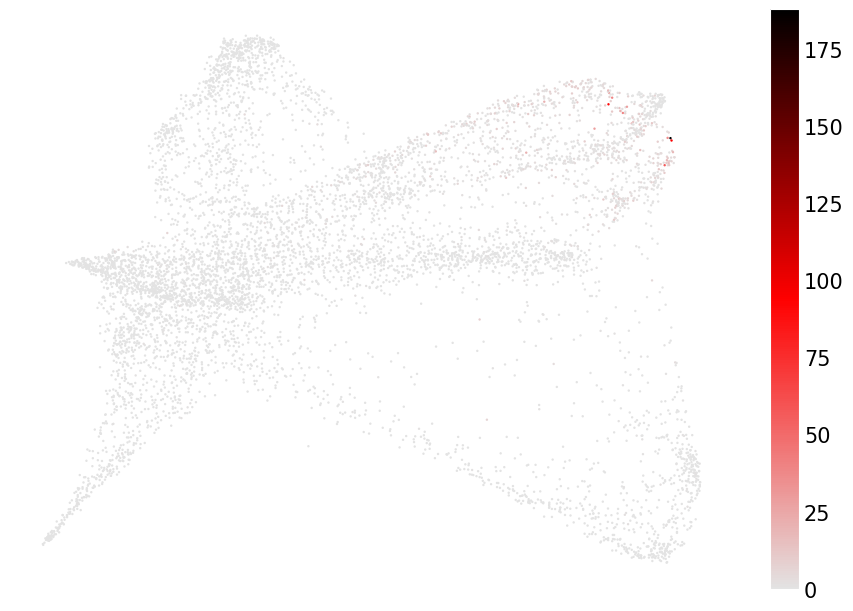

In [5]:
# define a colormap
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom', ['#e3e3e3', '#ff0000', '#000000'], N=256)

rna.obs['Krt71_t0'] = rna[:, 'Krt71'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt71_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the raw gene expression of Krt73.

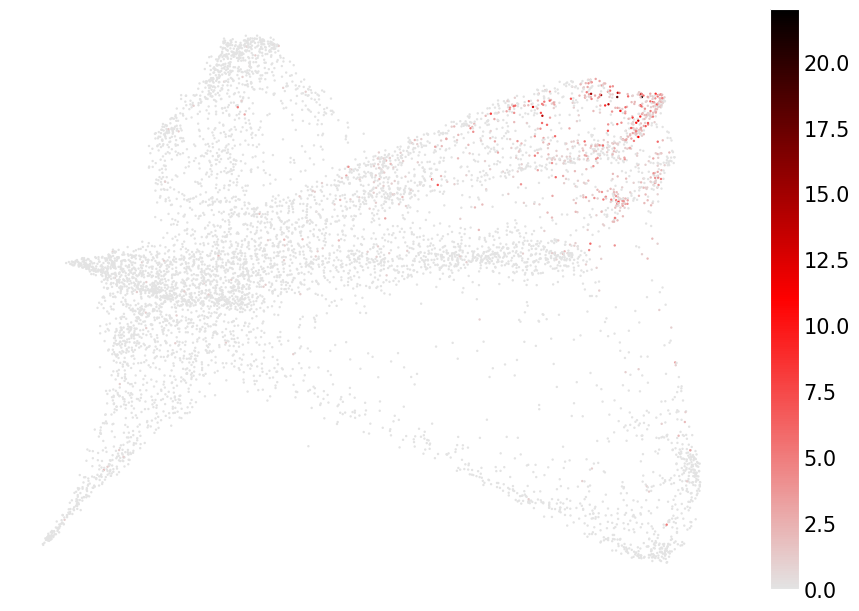

In [6]:
rna.obs['Krt73_t0'] = rna[:, 'Krt73'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt73_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Diffusion-based multimodal imputation with Ocelli requires multimodal eigenvectors and their corresponding eigenvalues. Add them to the `rna` object and impute `rna.X` using MDM-generated multimodal information.

In [7]:
rna.uns['eigenvectors'] = adata.uns['eigenvectors']
rna.uns['eigenvalues'] = adata.uns['eigenvalues']

oci.tl.imputation(rna, t=1)

Plot the imputed gene expression of Krt71.

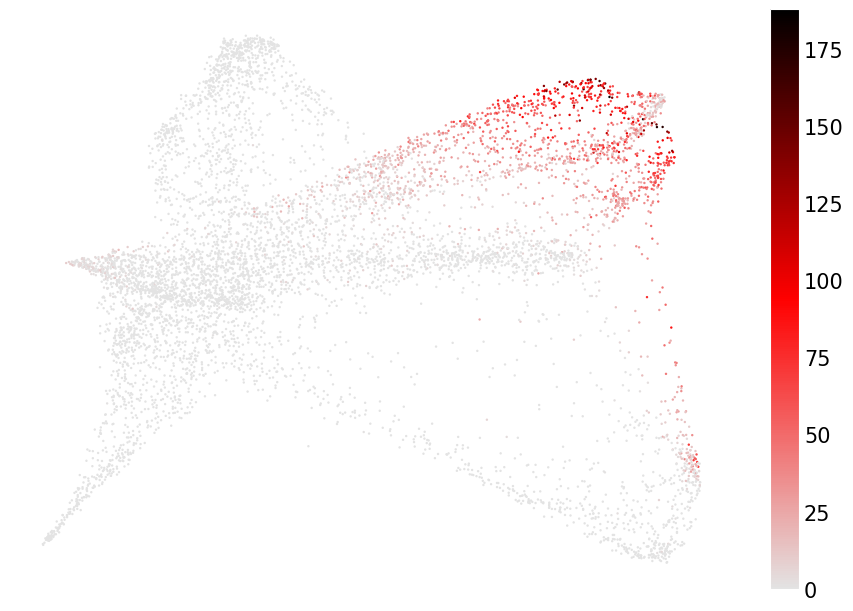

In [8]:
rna.obs['Krt71_t1'] = rna[:, 'Krt71'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt71_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the imputed gene expression of Krt73.

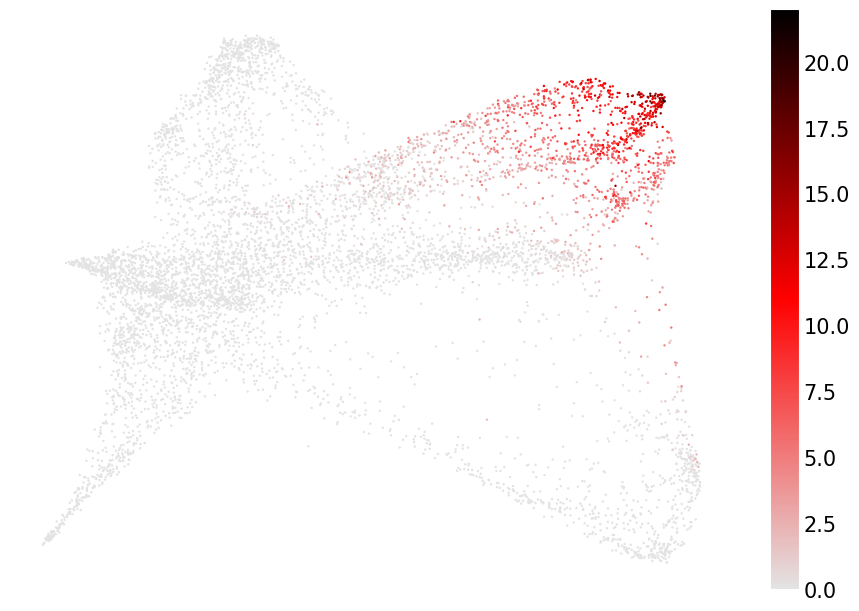

In [9]:
rna.obs['Krt73_t1'] = rna[:, 'Krt73'].X.toarray().flatten()

oci.pl.scatter(rna, x='X', c='Krt73_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Ocelli's multimodal imputation successfully strengthened the signal of both lowly expressed markers Krt71 and Krt73.

## Imputation of ATAC-seq peak activity

Repeat the above steps to impute the activity of Krt71 and Krt73 promoters. We found promoters of both markers using [GREAT](http://great.stanford.edu/great/public/html/).

In [10]:
promoters = {'Krt71': ['P_175393'], 'Krt73': ['P_337703']}

Load the raw promoter activity.

In [11]:
peaks = ad.read_h5ad('hair_follicle_atac_peaks.h5ad')[:, ['P_175393', 'P_337703']]
peaks.obsm['X'] = adata.obsm['X_proj']

Plot the raw activity of Krt71's promoter.

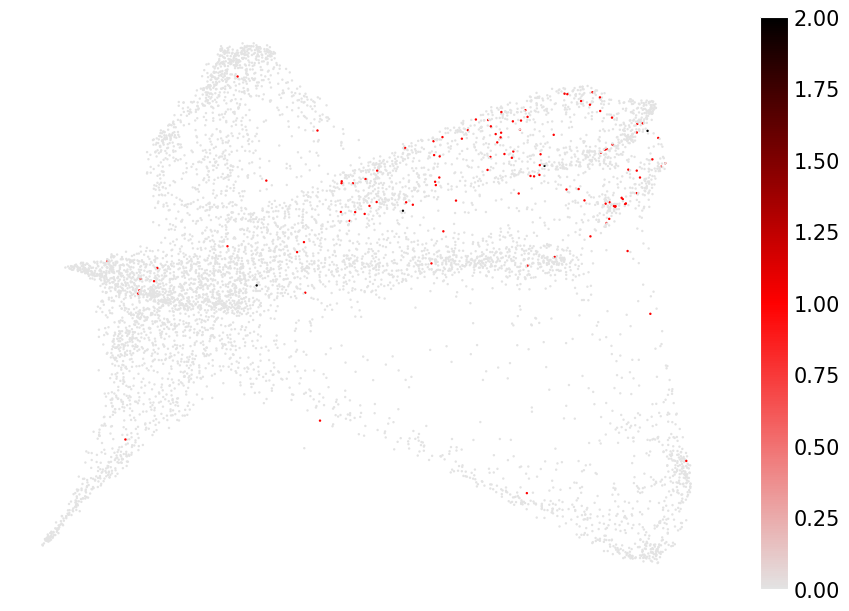

In [12]:
peaks.obs['Krt71_t0'] = peaks[:, promoters['Krt71']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt71_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the raw activity of Krt73's promoter.

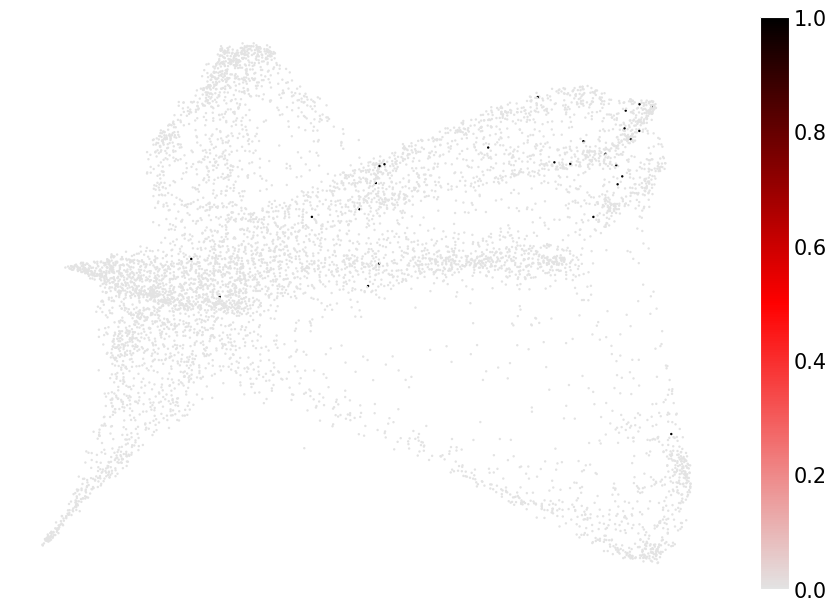

In [13]:
peaks.obs['Krt73_t0'] = peaks[:, promoters['Krt73']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt73_t0', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Add eigenvectors and eigenvalues to the `peaks` obejct.

In [14]:
peaks.uns['eigenvalues'] = adata.uns['eigenvalues']
peaks.uns['eigenvectors'] = adata.uns['eigenvectors']

oci.tl.imputation(peaks, t=1)

Plot the imputed activity of Krt71's promoter.

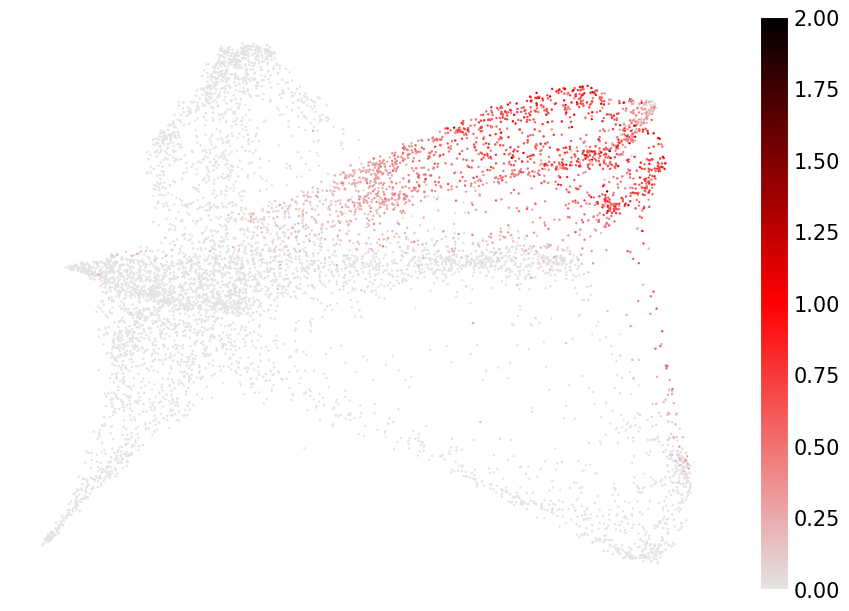

In [15]:
peaks.obs['Krt71_t1'] = peaks[:, promoters['Krt71']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt71_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Plot the imputed activity of Krt73's promoter.

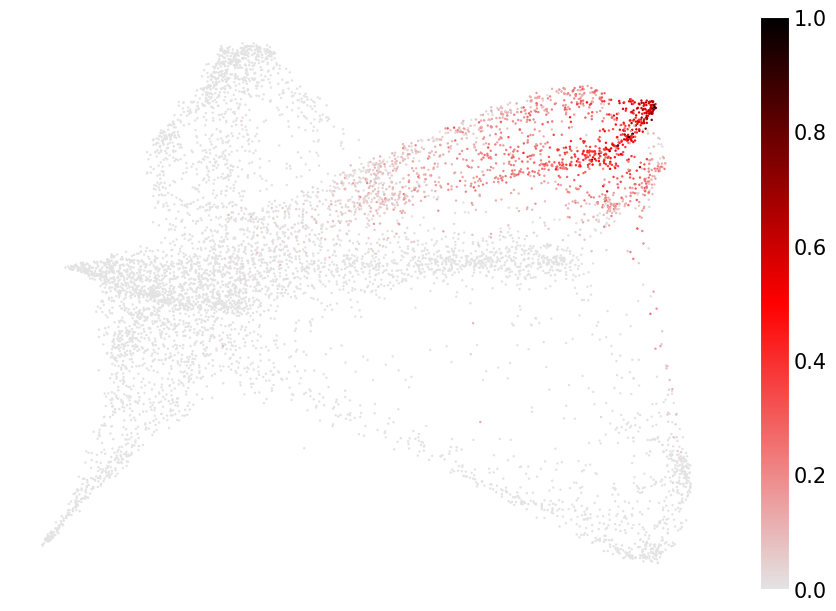

In [16]:
peaks.obs['Krt73_t1'] = peaks[:, promoters['Krt73']].X.toarray().flatten()

oci.pl.scatter(peaks, x='X', c='Krt73_t1', cmap=cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title='')

Ocelli successfully imputed chromatin accessibility levels at the promoters of Krt71 and Krt73 genes.

In Tutorial 4, you will explore a bimodal single-cell dataset of human bone marrow.